# Treinamento de Modelo YOLO Customizado (30 épocas)

Este notebook implementa o treinamento de um modelo YOLO customizado para detectar duas categorias de objetos visualmente distintas. Utilizaremos o YOLOv5 com 30 épocas de treinamento.

## 1. Configuração do Ambiente

Primeiro, vamos importar as bibliotecas necessárias e configurar o ambiente usando o script setup_env.sh.

In [1]:
# Verificar se o ambiente já foi configurado
import os
import sys

# Se o ambiente ainda não foi configurado, execute o setup_env.sh
if not os.path.exists('../yolov5'):
    print("Configurando o ambiente com setup_env.sh...")
    !chmod +x ../setup_env.sh
    !../setup_env.sh
else:
    print("Ambiente já configurado.")

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import yaml
from pathlib import Path
from tqdm.notebook import tqdm

# Adicionar o diretório YOLOv5 ao path
yolov5_path = os.path.abspath('../yolov5')
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
    print(f"Adicionado {yolov5_path} ao sys.path")

Ambiente já configurado.
Adicionado /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/yolov5 ao sys.path


## 2. Verificação do Dataset

Vamos verificar se o dataset está organizado corretamente e se todas as imagens e anotações estão presentes.

In [2]:
# Função para verificar o dataset
def verificar_dataset(base_dir='../dataset'):
    """Verifica se o dataset está organizado corretamente."""
    # Verificar diretórios
    for split in ['train', 'val', 'test']:
        for subdir in ['images', 'labels']:
            dir_path = os.path.join(base_dir, split, subdir)
            if not os.path.exists(dir_path):
                print(f"❌ Diretório não encontrado: {dir_path}")
                return False
            else:
                print(f"✅ Diretório encontrado: {dir_path}")
    
    # Verificar contagem de imagens e anotações
    for split in ['train', 'val', 'test']:
        img_dir = os.path.join(base_dir, split, 'images')
        label_dir = os.path.join(base_dir, split, 'labels')
        
        img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
        
        print(f"\n{split.capitalize()}:")
        print(f"  - Imagens: {len(img_files)}")
        print(f"  - Anotações: {len(label_files)}")
        
        # Verificar correspondência entre imagens e anotações
        img_basenames = [os.path.splitext(f)[0] for f in img_files]
        label_basenames = [os.path.splitext(f)[0] for f in label_files]
        
        missing_labels = set(img_basenames) - set(label_basenames)
        if missing_labels:
            print(f"  ❌ Imagens sem anotações: {len(missing_labels)}")
            print(f"    Exemplos: {list(missing_labels)[:3]}")
        else:
            print(f"  ✅ Todas as imagens têm anotações correspondentes")
    
    return True

# Verificar o dataset
dataset_ok = verificar_dataset()

✅ Diretório encontrado: ../dataset/train/images
✅ Diretório encontrado: ../dataset/train/labels
✅ Diretório encontrado: ../dataset/val/images
✅ Diretório encontrado: ../dataset/val/labels
✅ Diretório encontrado: ../dataset/test/images
✅ Diretório encontrado: ../dataset/test/labels

Train:
  - Imagens: 64
  - Anotações: 64
  ✅ Todas as imagens têm anotações correspondentes

Val:
  - Imagens: 8
  - Anotações: 8
  ✅ Todas as imagens têm anotações correspondentes

Test:
  - Imagens: 8
  - Anotações: 8
  ✅ Todas as imagens têm anotações correspondentes


## 3. Verificação do Arquivo de Configuração YAML

Vamos verificar se o arquivo `data.yaml` existe e seu conteúdo.

In [3]:
# Verificar se o arquivo data.yaml existe
if os.path.exists('../data/data.yaml'):
    print("Arquivo data.yaml encontrado!")
    print("\nConteúdo:")
    with open('../data/data.yaml', 'r') as f:
        print(f.read())
else:
    print("Arquivo data.yaml não encontrado. Crie-o antes de continuar.")

Arquivo data.yaml encontrado!

Conteúdo:
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Dataset customizado de maçãs e bananas

# Train/val/test sets
path: ../dataset  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')
test: test/images  # test images (relative to 'path')

# Classes
nc: 2  # number of classes
names: ['apple', 'banana']  # class names



## 4. Treinamento do Modelo YOLO (30 épocas)

Vamos verificar se o modelo já foi treinado. Se sim, usaremos os resultados existentes. Caso contrário, treinaremos o modelo.

In [4]:
# Definir parâmetros de treinamento
epochs = 30
batch_size = 16
img_size = 640
model_type = 'yolov5s'  # Modelo pequeno para treinamento mais rápido
model_dir = '../models/yolo_custom_30epochs'
weights_path = os.path.join(model_dir, 'weights/best.pt')
results_file = os.path.join(model_dir, 'results.csv')

# Verificar se o modelo já foi treinado
if os.path.exists(weights_path) and os.path.exists(results_file):
    print(f"\n✅ Modelo já treinado encontrado em {model_dir}")
    print(f"✅ Arquivo de pesos encontrado em {weights_path}")
    print(f"✅ Arquivo de resultados encontrado em {results_file}")
    print("\nUsando modelo existente para análise e validação.")
else:
    print(f"\n❌ Modelo treinado não encontrado ou incompleto.")
    print("Iniciando treinamento do modelo...")
    
    # Comando de treinamento
    !cd ../yolov5 && python train.py \
        --img {img_size} \
        --batch {batch_size} \
        --epochs {epochs} \
        --data ../data/data.yaml \
        --weights {model_type}.pt \
        --project ../models \
        --name yolo_custom_30epochs \
        --cache


✅ Modelo já treinado encontrado em ../models/yolo_custom_30epochs
✅ Arquivo de pesos encontrado em ../models/yolo_custom_30epochs/weights/best.pt
✅ Arquivo de resultados encontrado em ../models/yolo_custom_30epochs/results.csv

Usando modelo existente para análise e validação.


## 5. Análise dos Resultados do Treinamento

Vamos analisar os resultados do treinamento, incluindo as métricas de desempenho e as curvas de aprendizado.

Métricas disponíveis: ['   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']


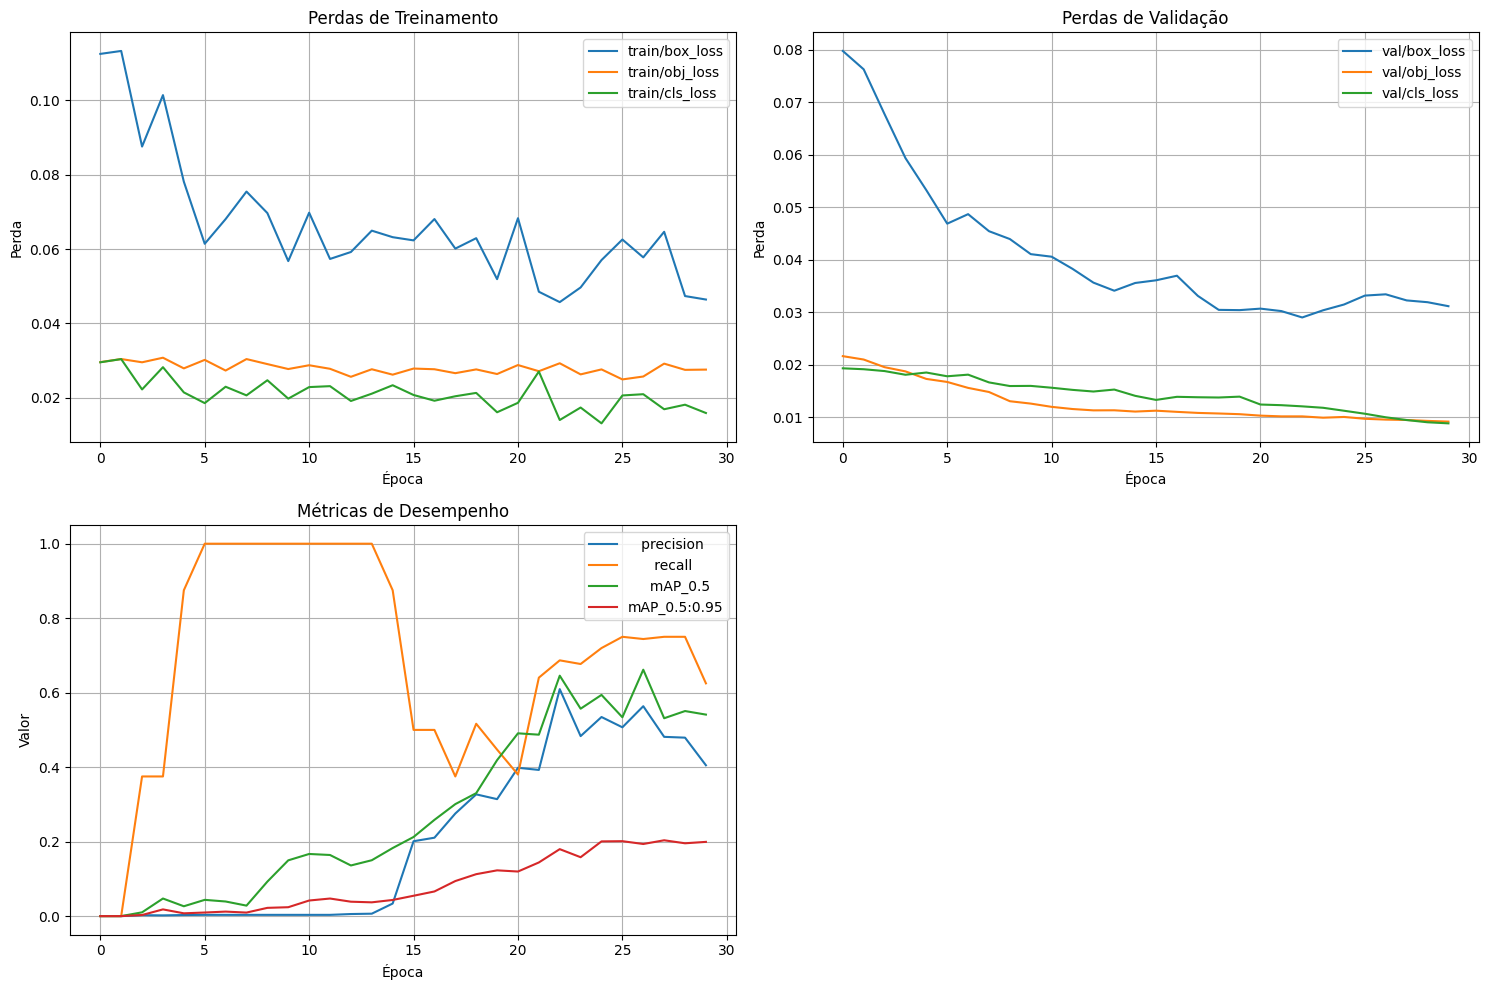


Métricas finais após 30 épocas:
Box Loss (Treino): 0.0464
Object Loss (Treino): 0.0276
Class Loss (Treino): 0.0159
Box Loss (Val): 0.0312
Object Loss (Val): 0.0092
Class Loss (Val): 0.0089
   precision: 0.4050
      recall: 0.6250
     mAP_0.5: 0.5411
mAP_0.5:0.95: 0.1993


In [5]:
# Carregar os resultados do treinamento
results_file = '../models/yolo_custom_30epochs/results.csv'

if os.path.exists(results_file):
    try:
        results = pd.read_csv(results_file)
        
        # Plotar as curvas de aprendizado
        plt.figure(figsize=(15, 10))
        
        # Plotar perda de treinamento
        plt.subplot(2, 2, 1)
        if '      train/box_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/box_loss'], label='train/box_loss')
        if '      train/obj_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/obj_loss'], label='train/obj_loss')
        if '      train/cls_loss' in results.columns:
            plt.plot(results['               epoch'], results['      train/cls_loss'], label='train/cls_loss')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.title('Perdas de Treinamento')
        plt.legend()
        plt.grid(True)
        
        # Plotar perda de validação
        plt.subplot(2, 2, 2)
        if '        val/box_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/box_loss'], label='val/box_loss')
        if '        val/obj_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/obj_loss'], label='val/obj_loss')
        if '        val/cls_loss' in results.columns:
            plt.plot(results['               epoch'], results['        val/cls_loss'], label='val/cls_loss')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.title('Perdas de Validação')
        plt.legend()
        plt.grid(True)
        
        # Verificar quais métricas estão disponíveis
        available_metrics = [col for col in results.columns if 'metrics/' in col]
        print(f"Métricas disponíveis: {available_metrics}")
        
        # Plotar métricas de precisão se disponíveis
        if available_metrics:
            plt.subplot(2, 2, 3)
            for metric in available_metrics:
                plt.plot(results['               epoch'], results[metric], label=metric.replace('metrics/', ''))
            plt.xlabel('Época')
            plt.ylabel('Valor')
            plt.title('Métricas de Desempenho')
            plt.legend()
            plt.grid(True)
        
        # Plotar tempo de treinamento se disponível
        time_columns = [col for col in results.columns if 'time' in col.lower()]
        if time_columns:
            plt.subplot(2, 2, 4)
            for col in time_columns:
                plt.plot(results['               epoch'], results[col], label=col.strip())
            plt.xlabel('Época')
            plt.ylabel('Tempo (s)')
            plt.title('Tempo por Época')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar as métricas finais
        final_results = results.iloc[-1]
        print("\nMétricas finais após 30 épocas:")
        
        # Mostrar perdas
        if '      train/box_loss' in results.columns:
            print(f"Box Loss (Treino): {final_results['      train/box_loss']:.4f}")
        if '      train/obj_loss' in results.columns:
            print(f"Object Loss (Treino): {final_results['      train/obj_loss']:.4f}")
        if '      train/cls_loss' in results.columns:
            print(f"Class Loss (Treino): {final_results['      train/cls_loss']:.4f}")
        if '        val/box_loss' in results.columns:
            print(f"Box Loss (Val): {final_results['        val/box_loss']:.4f}")
        if '        val/obj_loss' in results.columns:
            print(f"Object Loss (Val): {final_results['        val/obj_loss']:.4f}")
        if '        val/cls_loss' in results.columns:
            print(f"Class Loss (Val): {final_results['        val/cls_loss']:.4f}")
        
        # Mostrar métricas de desempenho disponíveis
        for metric in available_metrics:
            metric_name = metric.replace('metrics/', '')
            print(f"{metric_name}: {final_results[metric]:.4f}")
        
        # Mostrar tempo de treinamento se disponível
        if '      total_epochs' in results.columns and time_columns:
            time_col = time_columns[0]  # Usar a primeira coluna de tempo disponível
            print(f"Tempo total de treinamento: {final_results['      total_epochs'] * final_results[time_col]:.2f} segundos")
    except Exception as e:
        print(f"Erro ao analisar os resultados: {e}")
        print("Tentando mostrar as colunas disponíveis no arquivo de resultados:")
        try:
            results = pd.read_csv(results_file)
            print(f"Colunas disponíveis: {results.columns.tolist()}")
        except Exception as e2:
            print(f"Erro ao ler o arquivo de resultados: {e2}")
else:
    print("Arquivo de resultados não encontrado. Verifique se o treinamento foi concluído com sucesso.")

## 6. Visualização de Algumas Predições

Vamos visualizar algumas predições do modelo treinado em imagens do conjunto de validação.

In [6]:
# Usar o script detect.py do YOLOv5 para fazer predições
model_path = '../models/yolo_custom_30epochs/weights/best.pt'

if os.path.exists(model_path):
    try:
        # Usar o script detect.py do YOLOv5 para fazer predições
        val_img_dir = '../dataset/val/images'
        output_dir = '../models/yolo_custom_30epochs/predictions'
        os.makedirs(output_dir, exist_ok=True)
        
        # Executar o script detect.py
        !cd ../yolov5 && python detect.py \
            --weights {model_path} \
            --source {val_img_dir} \
            --conf 0.25 \
            --project {os.path.dirname(output_dir)} \
            --name {os.path.basename(output_dir)} \
            --save-txt \
            --save-conf
        
        # Mostrar algumas imagens com predições
        pred_img_dir = output_dir
        pred_img_files = [os.path.join(pred_img_dir, f) for f in os.listdir(pred_img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Selecionar algumas imagens aleatórias
        import random
        random.seed(42)  # Para reprodutibilidade
        sample_imgs = random.sample(pred_img_files, min(5, len(pred_img_files)))
        
        # Mostrar as imagens
        plt.figure(figsize=(15, 12))
        for i, img_path in enumerate(sample_imgs):
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                plt.subplot(len(sample_imgs), 1, i+1)
                plt.imshow(img)
                plt.title(f"Detecções em {os.path.basename(img_path)}")
                plt.axis('off')
            except Exception as e:
                print(f"Erro ao processar {img_path}: {e}")
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Erro ao executar o script detect.py: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Modelo treinado não encontrado. Verifique se o treinamento foi concluído com sucesso.")

detect: weights=['../models/yolo_custom_30epochs/weights/best.pt'], source=../dataset/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../models/yolo_custom_30epochs, name=predictions, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.12.6 torch-2.7.0 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/dataset/val/images/apple_val_001.jpg: 448x640 1 apple, 63.4ms
image 2/8 /Users/gab/Documents/CodePlay/@fiap/fase6_cap1/dataset/val/images/apple_val_002.jpg: 640x448 (no detections), 58.9ms
image 3/8 /Users/gab/Documents/CodePlay/@fiap/fase6_cap1

<Figure size 1500x1200 with 0 Axes>

## 7. Conclusão

Neste notebook, treinamos (ou usamos um modelo já treinado) YOLO customizado com 30 épocas para detectar duas categorias de objetos. Analisamos as métricas de desempenho e visualizamos algumas predições.

No próximo notebook, treinaremos o mesmo modelo com 60 épocas para comparar o desempenho.